In [1]:
cl = 'E118'
name = 'HEPG2'

In [2]:
import pickle
import torch
import torch_geometric

In [3]:
import networkx as nx
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn import preprocessing
import torch_geometric

with open('/gpfs_home/spate116/data/spate116/GCN/%s/data/data_class1_unflattened.pickle' % cl, 'rb') as f:
    data = pickle.load(f)
    data.x = data.x.reshape(data.x.shape[0], 1, data.x.shape[1], data.x.shape[2]).float()
    data.y = data.y.squeeze().long() 
    
graph = nx.read_gpickle("/gpfs_home/spate116/data/spate116/GCN/%s/data/graph.pickle" % cl)
weights = [x[2] for x in graph.edges.data('weight')]
robust_scaler = preprocessing.RobustScaler()
weights = np.ndarray.flatten(robust_scaler.fit_transform(np.array(weights).reshape(-1, 1)))
data.edge_attr = torch.tensor(weights).reshape(-1, 1).float()

G = data

with open('/gpfs_home/spate116/data/spate116/GCN/%s/data/conv.pickle' % cl, 'rb') as f:
    node_id_to_name = pickle.load(f)

In [4]:
from torch_geometric.nn import SAGEConv, ChebConv, TAGConv, GATConv, ARMAConv

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, num_classes):
        super(GCN, self).__init__()
        self.conv1 = ARMAConv(in_feats, hidden_size, 2)
        self.conv2 = ARMAConv(hidden_size, hidden_size1, 2)
        self.conv3 = ARMAConv(hidden_size1, hidden_size2, 2)
        self.conv4 = ARMAConv(hidden_size2, hidden_size3, 2)
        self.conv5 = ARMAConv(hidden_size3, hidden_size4, 2)
        self.conv6 = ARMAConv(hidden_size4, num_classes)
        x = 75
        self.encoder = nn.Sequential(
            nn.Conv2d(1, x, (3, 3)),
            nn.LeakyReLU(),
            nn.Dropout2d(),
            nn.Conv2d(x, 2*x, (3, 2)),
            nn.LeakyReLU(),
            nn.Dropout2d(),
            nn.Conv2d(2*x, 1, (3, 2))
        )

    def forward(self, x, edge_index):
        x = x.reshape(x.shape[0], 1, 100, 5)
        x = self.encoder(x).reshape(-1, 94)
        x = torch.tanh(x)
        x = F.dropout(x, training=self.training)
        x = self.conv1(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x, training=self.training)
        x = self.conv4(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x, training=self.training)
        x = self.conv5(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x, training=self.training)
        x = self.conv6(x, edge_index)
        x = F.softmax(x, dim=1)
        return x

In [5]:
import random
random.seed(30)
idx = list(range(G.num_nodes))
random.shuffle(idx)
train_mask = idx[:10000]
test_mask = idx[10000:]

model = GCN(94, 500, 400, 300, 150, 20, 2)

device = torch.device('cuda')
model = model.to(device)
data = data.to(device)

In [6]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve

def train_model(net, graph, epochs, learning_rate, train_mask, test_mask):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    weight_one = sum(graph.y.cpu().numpy().tolist())/len(graph.y)
    weight = torch.tensor([weight_one, 1-weight_one]).to(device)

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        model.train()
        logits = model(graph.x.float(), graph.edge_index)

        loss = F.cross_entropy(logits[train_mask], graph.y[train_mask], weight=weight)
        loss_test = F.cross_entropy(logits[test_mask], graph.y[test_mask], weight=weight)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()

    return model

In [7]:
model = train_model(model, G, 500, 0.00005, train_mask, test_mask)

100%|██████████| 500/500 [04:24<00:00,  1.89it/s]


In [8]:
from torch_geometric.nn import GNNExplainer

In [24]:
explainer = GNNExplainer(model, epochs = 5000)

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import sqrt
from matplotlib.pyplot import figure
%matplotlib inline
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import robust_scale

def plot_node_exp(explainer, node_idx, data, thresh, node_feat_mask = None, edge_mask = None, conv = node_id_to_name, neighbors = False):
    if node_feat_mask is None:
        node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x.reshape(data.x.shape[0], -1), data.edge_index)
    
    edges_sub = []
    for i in range(len(edge_mask)):
        if edge_mask[i] > thresh:
            edges_sub.append(i)
    new_edge_mask = edge_mask[edges_sub]
    new_edges_index = data.edge_index.t()[edges_sub].t()
    
    kwargs = {}
    if neighbors:
        kwargs['font_size'] = 3
        kwargs['node_size'] = 400
        n = new_edges_index[0].cpu().numpy()
        for node in n:
            nfm, em = explainer.explain_node(node.item(), data.x.reshape(data.x.shape[0], -1), data.edge_index)
            edges_sub = []
            for i in range(len(em)):
                if em[i] > thresh:
                    edges_sub.append(i)
            new_edge_mask = torch.cat([new_edge_mask, em[edges_sub]], dim=-1)
            new_edges_index = torch.cat([new_edges_index, data.edge_index.t()[edges_sub].t()], dim = -1)
    else:
        kwargs['font_size'] = kwargs.get('font_size') or 6
        kwargs['node_size'] = kwargs.get('node_size') or 800
    
    G = nx.DiGraph()
    for i in range(new_edges_index.shape[1]):
        G.add_edge(new_edges_index[0][i].item(), new_edges_index[1][i].item(), weight=new_edge_mask[i].item())
    new_y = data.y[list(G.nodes)]
    G = nx.relabel_nodes(G, conv)
    
    kwargs['with_labels'] = kwargs.get('with_labels') or True
    kwargs['cmap'] = kwargs.get('cmap') or 'coolwarm'

    pos = nx.spring_layout(G)
    fig, ax = plt.subplots(figsize=(8, 8), dpi=250, frameon=False)
    ax.axis('off')
    spec = mpl.gridspec.GridSpec(ncols=2, nrows=3, figure=fig, height_ratios=[6, 1, 0.2], width_ratios=[.8, .15], wspace = 0.0)
    ax1 = fig.add_subplot(spec[0, :])
    ax2 = fig.add_subplot(spec[1, 0])
    ax3 = fig.add_subplot(spec[2, 0])
    ax4 = fig.add_subplot(spec[1, 1])
    ax5 = fig.add_subplot(spec[2, 1])
    ax1.axis('off')
    ax5.axis('off')
    fig.suptitle('%s: Edge and HM Importance for %s (%s)' % (name, conv[node_idx], 'Up' if data.y[node_idx].item() == 1 else 'Down'))
    for source, target, data in G.edges(data=True):
        ax1.annotate(
            '', xy=pos[target], xycoords='data', xytext=pos[source],
            textcoords='data', arrowprops=dict(
                arrowstyle="->",
                alpha=max(float(data['weight']), 0.1),
                shrinkA=sqrt(kwargs['node_size']) / 2.0,
                shrinkB=sqrt(kwargs['node_size']) / 2.0,
                connectionstyle="arc3,rad=0.1",
            ))
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_color=new_y.tolist(), label='Expression', **kwargs)
    nx.draw_networkx_labels(G, pos, ax=ax1, **kwargs)
    a = node_feat_mask.reshape(5, 100).cpu().numpy()
    new_matrix = robust_scale(a.flatten(), with_centering = True).reshape(5, 100)
    df = pd.DataFrame(new_matrix)
    df.index = ['H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3', 'H3K9me3']
    ax2 = sns.heatmap(df, ax=ax2, yticklabels = df.index, xticklabels=False, cmap="coolwarm", cbar_ax = ax3, cbar_kws={"orientation": "horizontal", 'label': 'Importance Score'})
    ax4 = sns.barplot(x = df.sum(axis=1), y = df.index, ax = ax4)
    ax4.axis('off')
    return node_feat_mask, edge_mask, G, fig

In [29]:
node_feat_mask, edge_mask = None, None

Explain node 5: 100%|██████████| 5000/5000 [55:22<00:00,  1.50it/s]


tensor([], device='cuda:0', size=(2, 0), dtype=torch.int64)


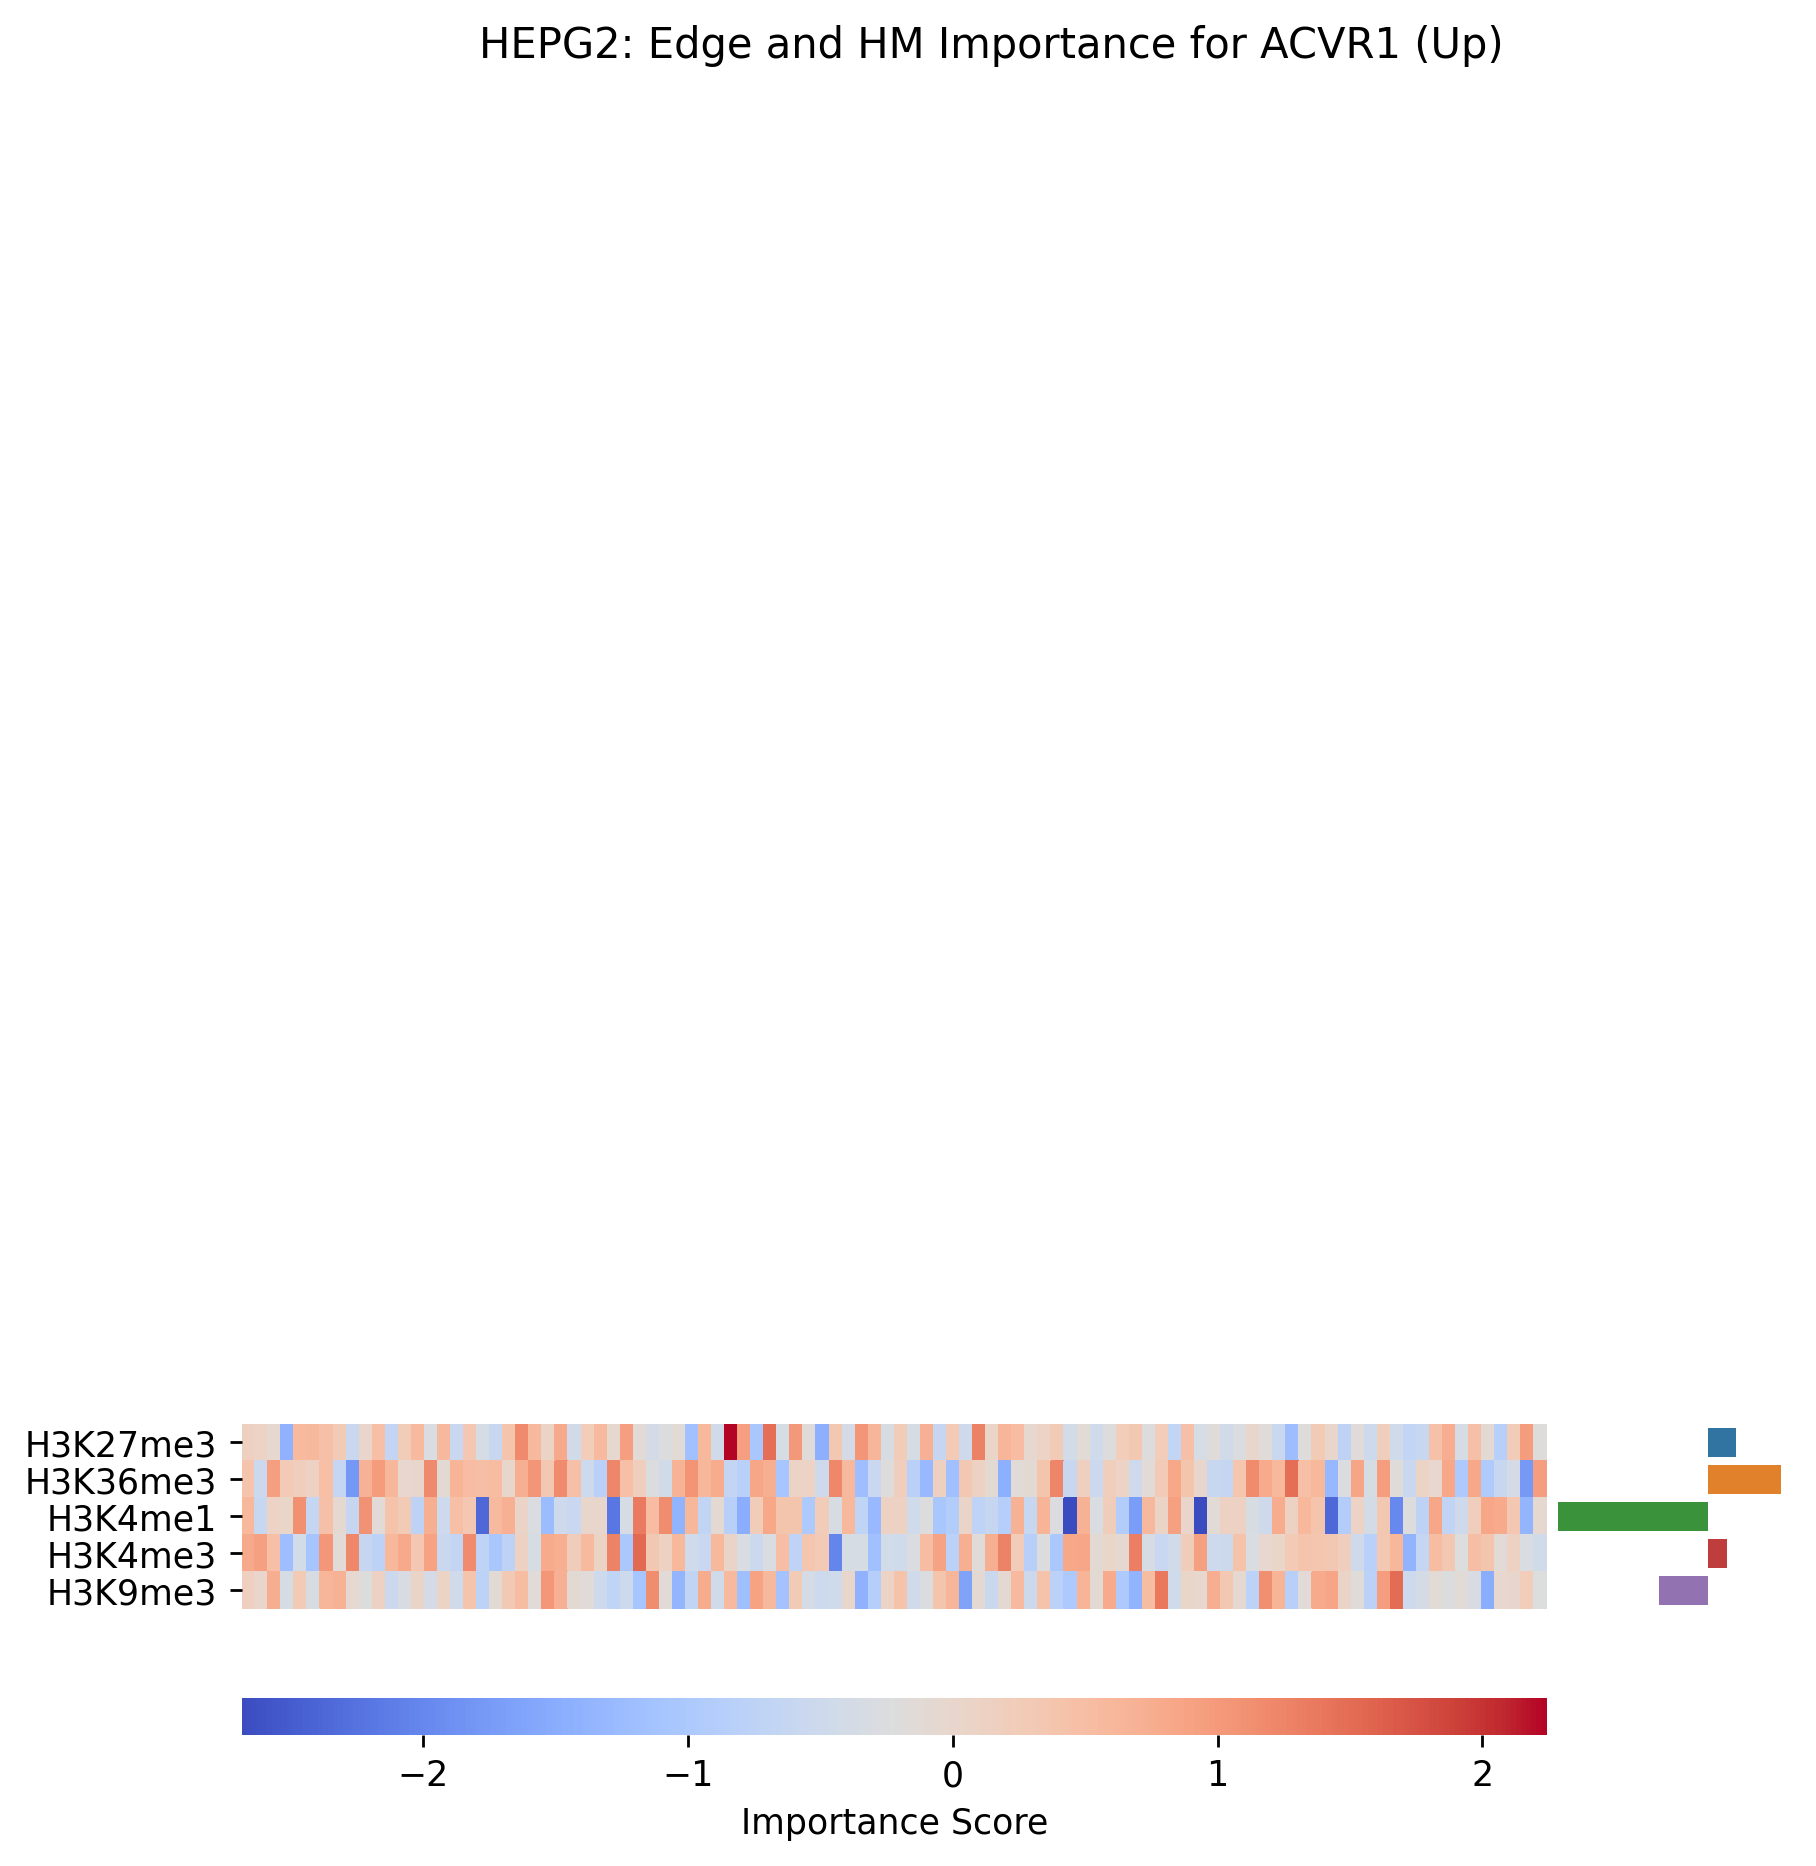

In [30]:
node_feat_mask, edge_mask, _, _ = plot_node_exp(explainer, 5, data, 0.25, node_feat_mask, edge_mask, node_id_to_name, False)

In [13]:
idx = data.edge_index[1] == 5000
neigh = list(zip(data.edge_index.t()[idx], data.edge_attr[idx]))
neigh.sort(key = lambda x: -x[1].item())
for row in neigh[:10]:
    print(str(row))

(tensor([8131, 5000], device='cuda:0'), tensor([6.8945], device='cuda:0'))
(tensor([2431, 5000], device='cuda:0'), tensor([5.1180], device='cuda:0'))
(tensor([3981, 5000], device='cuda:0'), tensor([4.8388], device='cuda:0'))
(tensor([7164, 5000], device='cuda:0'), tensor([4.5596], device='cuda:0'))
(tensor([6280, 5000], device='cuda:0'), tensor([3.5454], device='cuda:0'))
(tensor([8528, 5000], device='cuda:0'), tensor([2.6980], device='cuda:0'))
(tensor([8515, 5000], device='cuda:0'), tensor([2.3002], device='cuda:0'))
(tensor([1325, 5000], device='cuda:0'), tensor([1.9821], device='cuda:0'))
(tensor([11482,  5000], device='cuda:0'), tensor([1.9238], device='cuda:0'))
(tensor([ 590, 5000], device='cuda:0'), tensor([1.8035], device='cuda:0'))
